# Introduction to Telstra competition


This is the dataset that is used in the Telstra Network Disruptions competition that ran between Nov 2015 and Feb 2016
This competition provided a very nice and small dataset that allows many aspects of predictive modelling:

* relational data between different entities of the disruption data
* clean dataset that provides consistent and reliable feedback
* ideal for practices for many parts of the predictive modelling pipelin: feature engineering, cross-validation, stacking, etc
* Magic Feature! see forum thread for more details :)
* This dataset is re-uploaded since the original competition did not feature kernels, and it is made available here give people a chance to practice their data science/predictive modelling skill with this nice little dataset

# content




* The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files.

* Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many).

* Different types of features are extracted from log files and other sources: eventtype.csv, logfeature.csv, resourcetype.csv, severitytype.csv.

* Note: “severitytype” is a feature extracted from the log files (in severitytype.csv). Often this is a severity type of a warning message coming from the log. "severitytype" is categorical. It does not have an ordering. “faultseverity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

In [172]:
# Load the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf                      # to allow RNN and LSTM models
%matplotlib inline

# Load the data

In [173]:
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
sample_submission = pd.read_csv('sample_submission.csv')
severity_type = pd.read_csv('severity_type.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [174]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [175]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [176]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [177]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


In [178]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


# 1. Lets do Exploratory data analysis ( EDA )

## analyse Train set

In [179]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.1+ KB


In [180]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [181]:
len(train.index)

7381

In [182]:
len(train.id.unique())

7381

In [183]:
len(train.location.unique())

929

In [184]:
len(train.fault_severity.unique())

3

In [185]:
train.isnull().sum()

id                0
location          0
fault_severity    0
dtype: int64

## Analysis Test set

In [186]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11171 non-null  int64 
 1   location  11171 non-null  object
dtypes: int64(1), object(1)
memory usage: 174.7+ KB


In [187]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [188]:
len(test.index)

11171

In [189]:
len(test.id.unique())

11171

In [190]:
len(test.location.unique())

1039

In [191]:
test.isnull().sum()

id          0
location    0
dtype: int64

# combining training and test data into a single data set

In [192]:
# creating a colum of istrain in both train and test data

train['istrain'] = 1
test['istrain'] = 0

data = train.append(test)

# analysis data

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18552 non-null  int64  
 1   location        18552 non-null  object 
 2   fault_severity  7381 non-null   float64
 3   istrain         18552 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 724.7+ KB


In [194]:
data.head()

,id,location,fault_severity,istrain
0,14121,location 118,1.0,1
1,9320,location 91,0.0,1
2,14394,location 152,1.0,1
3,8218,location 931,1.0,1
4,14804,location 120,0.0,1


In [195]:
print('total number of rows in data: ' , len(data.index))
print('number of unique id :' , len(data.id.unique()))
print('number of unique locations:' , len(data.location.unique()))
print('number of unique fault severity:' , len(data.fault_severity.unique()))

total number of rows in data:  18552
number of unique id : 18552
number of unique locations: 1126
number of unique fault severity: 4


In [196]:
data.isnull().sum()

id                    0
location              0
fault_severity    11171
istrain               0
dtype: int64

# cleaning the data

In [197]:
# we will strip the location attribute and maintain the interger value of location

data.location = data.location.str.lstrip('location').astype('int')
data.head()

,id,location,fault_severity,istrain
0,14121,118,1.0,1
1,9320,91,0.0,1
2,14394,152,1.0,1
3,8218,931,1.0,1
4,14804,120,0.0,1


# visualizing the data

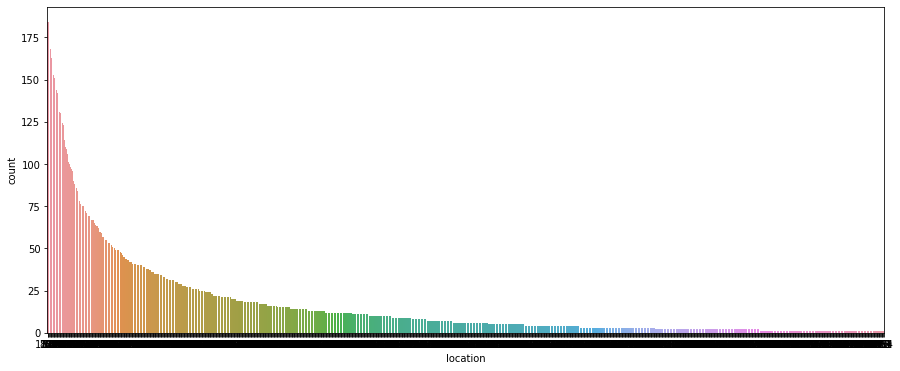

In [198]:
plt.figure(figsize=(15,6))
col = 'location'
sns.countplot(x = col , data = data , order=data[col].value_counts().index)

Text(0, 0.5, 'frequency')

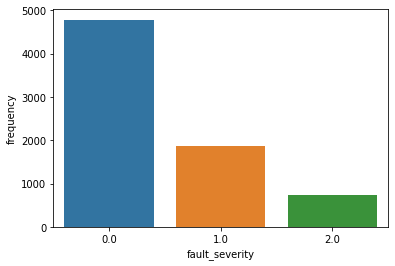

In [199]:
sns.countplot(x = 'fault_severity' , data = data)
plt.ylabel('frequency')

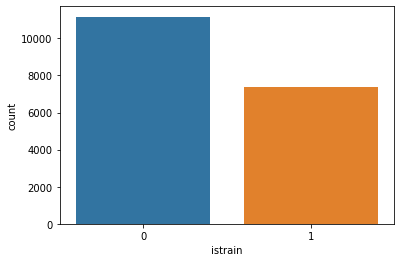

In [200]:
sns.countplot(x = 'istrain' , data = data)

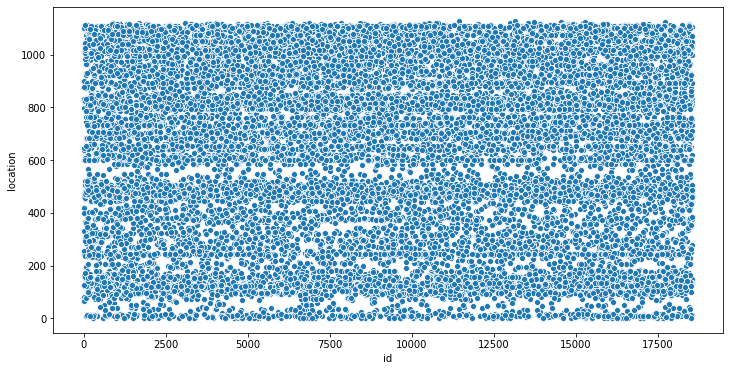

In [201]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'id' , y='location' , data= data  , cmap = 'virdis')

# Analysis event type

In [202]:
event_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31170 non-null  int64 
 1   event_type  31170 non-null  object
dtypes: int64(1), object(1)
memory usage: 487.2+ KB


In [203]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [204]:
len(event_type.index)

31170

In [205]:
len(event_type.id.unique())

18552

In [206]:
len(event_type.event_type.unique())

53

In [207]:
event_type.isnull().sum()

id            0
event_type    0
dtype: int64

# cleaning event type

In [208]:
event_type.event_type = event_type.event_type.str.lstrip('event_type').astype('int')
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


In [209]:
# one hot encoding using pandas

event_type = pd.get_dummies(event_type)
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


# analysis Log features

In [210]:
log_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           58671 non-null  int64 
 1   log_feature  58671 non-null  object
 2   volume       58671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [211]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [212]:
print('total number of rows : ' , len(log_feature.index))
print('number of unique ids :' , len(log_feature.id.unique()))
print('number of unique log features:' , len(log_feature.log_feature.unique()))
print('number of unique volumes :' , len(log_feature.volume.unique()))


total number of rows :  58671
number of unique ids : 18552
number of unique log features: 386
number of unique volumes : 341


In [213]:
log_feature.isnull().sum()

id             0
log_feature    0
volume         0
dtype: int64

# cleaning log features

In [214]:
log_feature['log_feature'] = log_feature['log_feature'].str.lstrip('feature').astype('int')
log_feature.head()

,id,log_feature,volume
0,6597,68,6
1,8011,68,7
2,2597,68,1
3,5022,172,2
4,5022,56,1


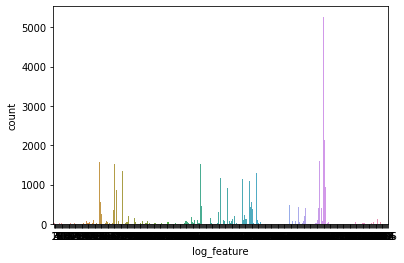

In [215]:
sns.countplot(x = 'log_feature' , data = log_feature)

# Analysis resourse type

In [216]:
resource_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             21076 non-null  int64 
 1   resource_type  21076 non-null  object
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [217]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [218]:
# clean the data of resourse type

resource_type['resource_type'] = resource_type['resource_type'].str.lstrip('resource_type').astype('int')
resource_type.head()

,id,resource_type
0,6597,8
1,8011,8
2,2597,8
3,5022,8
4,6852,8


In [219]:
resource_type['resource_type'].value_counts()

8     10268
2      8918
6       582
7       498
4       330
9       190
3       145
10       73
1        58
5        14
Name: resource_type, dtype: int64

In [220]:
resource_type = pd.get_dummies(resource_type , columns=['resource_type'])
resource_type.head()

,id,resource_type_1,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9,resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


# Analysis severity type

In [221]:
severity_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             18552 non-null  int64 
 1   severity_type  18552 non-null  object
dtypes: int64(1), object(1)
memory usage: 290.0+ KB


In [222]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [223]:
# cleaning the severity data

severity_type['severity_type'] = severity_type['severity_type'].str.lstrip('severity_type').astype('int')
severity_type.head()

,id,severity_type
0,6597,2
1,8011,2
2,2597,2
3,5022,1
4,6852,1


In [224]:
severity_type['severity_type'].value_counts()

2    8737
1    8728
4    1014
5      65
3       8
Name: severity_type, dtype: int64

In [225]:
# one hot encoding
severity_type = pd.get_dummies(severity_type , columns=['severity_type'])
severity_type.head()

,id,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5
0,6597,0,1,0,0,0
1,8011,0,1,0,0,0
2,2597,0,1,0,0,0
3,5022,1,0,0,0,0
4,6852,1,0,0,0,0


# analysis submission data

In [226]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         11171 non-null  int64
 1   predict_0  11171 non-null  int64
 2   predict_1  11171 non-null  int64
 3   predict_2  11171 non-null  int64
dtypes: int64(4)
memory usage: 349.2 KB


In [227]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


# **Feature Engineering**

In [228]:
event_type = event_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

event_type.head()

,id,sum_event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,26
4,6852,26


In [229]:
log_feature = log_feature.groupby('id', sort=False).agg(count_log_feature=('log_feature','count'), 
                                                        sum_volume=('volume', 'sum'),
                                                        mean_volume=('volume', 'mean')
                                                      ).reset_index()
log_feature.head()

,id,count_log_feature,sum_volume,mean_volume
0,6597,1,6,6.000000
1,8011,1,7,7.000000
2,2597,1,1,1.000000
3,5022,4,10,2.500000
4,6852,3,5,1.666667


In [230]:
resource_type = resource_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

resource_type.head()

,id,sum_resource_type_1,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


In [231]:
dfs = [data, log_feature, severity_type, resource_type, event_type] 
df1 = pd.merge(data , log_feature)
df2 = pd.merge(df1 , severity_type)
df3 = pd.merge(df2 , resource_type)
result = pd.merge(df3 , event_type)

result.shape

(18552, 23)

In [232]:
data.shape , log_feature.shape , severity_type.shape , resource_type.shape , event_type.shape

((18552, 4), (18552, 4), (18552, 6), (18552, 11), (18552, 2))

In [233]:
result.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,1,0,0,26
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,1,0,0,0,0,0,1,0,0,101


In [234]:
result.isnull().sum()

id                          0
location                    0
fault_severity          11171
istrain                     0
count_log_feature           0
sum_volume                  0
mean_volume                 0
severity_type_1             0
severity_type_2             0
severity_type_3             0
severity_type_4             0
severity_type_5             0
sum_resource_type_1         0
sum_resource_type_2         0
sum_resource_type_3         0
sum_resource_type_4         0
sum_resource_type_5         0
sum_resource_type_6         0
sum_resource_type_7         0
sum_resource_type_8         0
sum_resource_type_9         0
sum_resource_type_10        0
sum_event_type              0
dtype: int64

# Now its time to split the train and test data set

In [235]:
train = result[result['istrain'] == 1]
train.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,1,0,0,26
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,1,0,0,0,0,0,1,0,0,101


In [236]:
test = result[result['istrain'] == 0]
test.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
7381,11066,481,NaN,0,4,98,24.5,0,1,0,...,1,0,0,0,0,0,0,0,0,69
7382,18000,962,NaN,0,2,29,14.5,1,0,0,...,0,0,0,0,0,0,1,0,0,26
7383,16964,491,NaN,0,2,21,10.5,0,1,0,...,1,0,0,0,0,0,0,0,0,69
7384,4795,532,NaN,0,3,3,1.0,0,0,0,...,0,1,0,0,0,0,0,1,0,37
7385,3392,600,NaN,0,2,8,4.0,0,1,0,...,0,0,0,0,0,0,1,0,0,15


# Split the data into training and test sets

In [237]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

X = train.drop(columns='fault_severity')

# Prediction target - Training data
y = train['fault_severity']

# Selected features - Test data
x = test.drop(columns='fault_severity')

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Train Validation Split Complete")

Train Validation Split Complete


# Scalling

In [238]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [239]:
X_train.shape , X_valid.shape

((5904, 22), (1477, 22))

In [240]:
print(tf.__version__)

2.1.0


# Data Modelling

In [190]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(16 , activation = 'relu'))
model.add(Dense(16 , activation = 'relu'))
model.add(Dense(16 , activation = 'relu'))
model.add(Dense(16 , activation = 'relu'))

model.add(Dense(1))


In [191]:
model.compile(optimizer = 'adam' , loss = 'mse' , metrics = ['accuracy'])

# training the model

In [98]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 200)

Train on 5904 samples, validate on 1477 samples
Epoch 1/200
5904/5904 [==============================] - 5s 800us/sample - loss: 0.5000 - accuracy: 0.6369 - val_loss: 0.4360 - val_accuracy: 0.5904
Epoch 2/200
5904/5904 [==============================] - 0s 72us/sample - loss: 0.4019 - accuracy: 0.5671 - val_loss: 0.4023 - val_accuracy: 0.5443
Epoch 3/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.3867 - accuracy: 0.5462 - val_loss: 0.3950 - val_accuracy: 0.5410
Epoch 4/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.3823 - accuracy: 0.5473 - val_loss: 0.3928 - val_accuracy: 0.5450
Epoch 5/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.3796 - accuracy: 0.5486 - val_loss: 0.3913 - val_accuracy: 0.5437
Epoch 6/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.3784 - accuracy: 0.5496 - val_loss: 0.3896 - val_accuracy: 0.5464
Epoch 7/200
5904/5904 [==============================] - 0s 31u

Epoch 56/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.3143 - accuracy: 0.6323 - val_loss: 0.3359 - val_accuracy: 0.6283
Epoch 57/200
5904/5904 [==============================] - 0s 37us/sample - loss: 0.3159 - accuracy: 0.6260 - val_loss: 0.3324 - val_accuracy: 0.6195
Epoch 58/200
5904/5904 [==============================] - 0s 38us/sample - loss: 0.3141 - accuracy: 0.6328 - val_loss: 0.3363 - val_accuracy: 0.6107
Epoch 59/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.3145 - accuracy: 0.6299 - val_loss: 0.3325 - val_accuracy: 0.6080
Epoch 60/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.3122 - accuracy: 0.6279 - val_loss: 0.3354 - val_accuracy: 0.6276
Epoch 61/200
5904/5904 [==============================] - 0s 29us/sample - loss: 0.3156 - accuracy: 0.6287 - val_loss: 0.3325 - val_accuracy: 0.6080
Epoch 62/200
5904/5904 [==============================] - 0s 28us/sample - loss: 0.3121 - accuracy: 0.6303

Epoch 111/200
5904/5904 [==============================] - 0s 34us/sample - loss: 0.3016 - accuracy: 0.6506 - val_loss: 0.3234 - val_accuracy: 0.6249
Epoch 112/200
5904/5904 [==============================] - 0s 29us/sample - loss: 0.3015 - accuracy: 0.6419 - val_loss: 0.3253 - val_accuracy: 0.6263
Epoch 113/200
5904/5904 [==============================] - 0s 36us/sample - loss: 0.3016 - accuracy: 0.6430 - val_loss: 0.3243 - val_accuracy: 0.6263
Epoch 114/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.3010 - accuracy: 0.6477 - val_loss: 0.3223 - val_accuracy: 0.6249
Epoch 115/200
5904/5904 [==============================] - 0s 29us/sample - loss: 0.2999 - accuracy: 0.6389 - val_loss: 0.3242 - val_accuracy: 0.6242
Epoch 116/200
5904/5904 [==============================] - 0s 26us/sample - loss: 0.3020 - accuracy: 0.6475 - val_loss: 0.3261 - val_accuracy: 0.6121
Epoch 117/200
5904/5904 [==============================] - 0s 28us/sample - loss: 0.3023 - accuracy:

5904/5904 [==============================] - 0s 36us/sample - loss: 0.2927 - accuracy: 0.6467 - val_loss: 0.3160 - val_accuracy: 0.6351
Epoch 166/200
5904/5904 [==============================] - 0s 38us/sample - loss: 0.2925 - accuracy: 0.6514 - val_loss: 0.3218 - val_accuracy: 0.6385
Epoch 167/200
5904/5904 [==============================] - 0s 37us/sample - loss: 0.2946 - accuracy: 0.6596 - val_loss: 0.3235 - val_accuracy: 0.6026
Epoch 168/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.2937 - accuracy: 0.6419 - val_loss: 0.3153 - val_accuracy: 0.6209
Epoch 169/200
5904/5904 [==============================] - 0s 36us/sample - loss: 0.2918 - accuracy: 0.6494 - val_loss: 0.3176 - val_accuracy: 0.6290
Epoch 170/200
5904/5904 [==============================] - 0s 29us/sample - loss: 0.2916 - accuracy: 0.6506 - val_loss: 0.3194 - val_accuracy: 0.6391
Epoch 171/200
5904/5904 [==============================] - 0s 37us/sample - loss: 0.2934 - accuracy: 0.6528 - val_

In [99]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  368       
_________________________________________________________________
dense_31 (Dense)             multiple                  272       
_________________________________________________________________
dense_32 (Dense)             multiple                  272       
_________________________________________________________________
dense_33 (Dense)             multiple                  272       
_________________________________________________________________
dense_34 (Dense)             multiple                  17        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.history.history

{'loss': [0.5000445915431511,
  0.40185714187983895,
  0.3866503875106977,
  0.3822721925369769,
  0.37960640290565284,
  0.3783649981910297,
  0.37611011712531733,
  0.37365892109509086,
  0.37130347903827987,
  0.36998384011793267,
  0.3682868173774988,
  0.36537591164028094,
  0.36202946394116575,
  0.35974386560561533,
  0.35747673469507274,
  0.35592512346218597,
  0.35403740922933025,
  0.351518245731912,
  0.34983464162847216,
  0.34785275787195863,
  0.34501792672203807,
  0.34178395129154693,
  0.3407169697568992,
  0.3380737722243074,
  0.33586484613780404,
  0.3331431237662711,
  0.3341376532707111,
  0.3296824791405582,
  0.3287283729731552,
  0.3272346249683116,
  0.32539503716517915,
  0.32273127603013985,
  0.3247113466908938,
  0.32481899639455286,
  0.32160548980885406,
  0.32298403639134354,
  0.3267383453080325,
  0.32163177442744495,
  0.3194719998817134,
  0.319760916598121,
  0.31863031978529643,
  0.31839827470340054,
  0.3196432260963006,
  0.3213632111626912,
 

In [103]:
losses = pd.DataFrame(model.history.history)

<Figure size 864x1080 with 0 Axes>

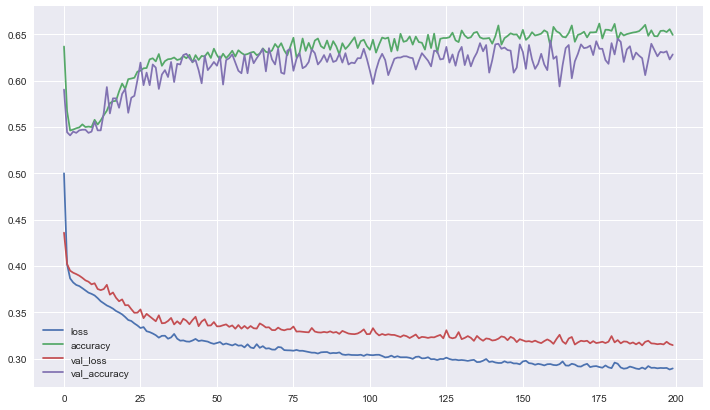

In [113]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses.plot(kind = 'line' , figsize=(12,7))

# Evaluation on Test data

In [114]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score , explained_variance_score

In [115]:
y_preds = model.predict(X_valid)

In [116]:
mean_absolute_error(y_valid , y_preds)

0.41949333719399706

In [117]:
mean_squared_error(y_valid  , y_preds)

0.3146977096036329

In [118]:
explained_variance_score(y_valid , y_preds)

0.31078047332196423

In [119]:
np.sqrt(mean_squared_error(y_valid , y_preds))

0.560979241686921

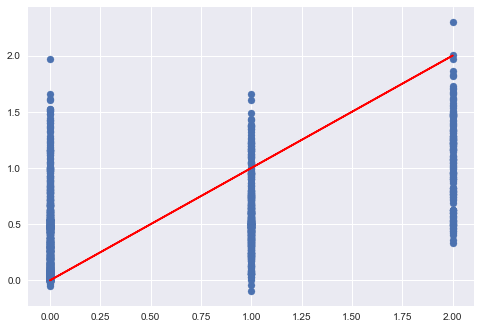

In [125]:
# our prediction

plt.scatter(y_valid , y_preds);

plt.plot(y_valid , y_valid , 'r')

In [122]:
y_valid.shape

(1477,)

In [123]:
errors = y_valid.values.reshape(1477 , 1) - y_preds

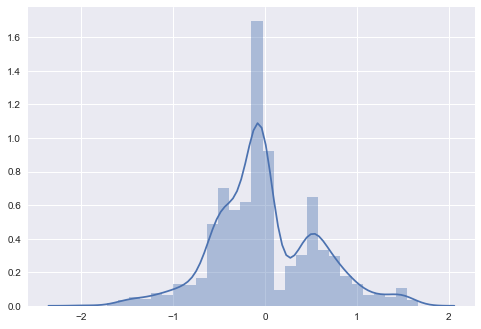

In [127]:
sns.distplot(errors , bins = 30)

# Training the model using LSTM ( Long Short Term Memory ) Neural network

In [248]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM ,Embedding
from tensorflow.keras.optimizers import Adam

#model = Sequential()

#model.add(LSTM(22 , input_shape = (22 , 1)))
#model.add(LSTM(22))
#model.add(LSTM(22))
#model.add(LSTM(22))

#model.add(LSTM(1 , input_shape = ()))
#model.add(Activation('softmax'))

In [255]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 22 internal units.
model.add(LSTM(22))

# Add a Dense layer with 10 units.
model.add(Dense(10))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
lstm_11 (LSTM)               (None, 22)                7656      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                230       
Total params: 71,886
Trainable params: 71,886
Non-trainable params: 0
_________________________________________________________________


In [256]:
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['categorical_accuracy'] )

In [257]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 50)

Train on 5904 samples, validate on 1477 samples
Epoch 1/50
5904/5904 [==============================] - 5s 908us/sample - loss: 1.0582 - categorical_accuracy: 0.6531 - val_loss: 0.8575 - val_categorical_accuracy: 1.0000
Epoch 2/50
5904/5904 [==============================] - 1s 194us/sample - loss: 0.8461 - categorical_accuracy: 1.0000 - val_loss: 0.8460 - val_categorical_accuracy: 1.0000
Epoch 3/50
5904/5904 [==============================] - 1s 196us/sample - loss: 0.8364 - categorical_accuracy: 1.0000 - val_loss: 0.8340 - val_categorical_accuracy: 1.0000
Epoch 4/50
5904/5904 [==============================] - 1s 198us/sample - loss: 0.8293 - categorical_accuracy: 0.9992 - val_loss: 0.8652 - val_categorical_accuracy: 0.9926
Epoch 5/50
5904/5904 [==============================] - 1s 196us/sample - loss: 0.8409 - categorical_accuracy: 0.9985 - val_loss: 0.8535 - val_categorical_accuracy: 0.9885
Epoch 6/50
5904/5904 [==============================] - 1s 198us/sample - loss: 0.8429 - cat

5904/5904 [==============================] - 1s 192us/sample - loss: 0.7940 - categorical_accuracy: 0.9929 - val_loss: 0.7924 - val_categorical_accuracy: 0.9871
Epoch 49/50
5904/5904 [==============================] - 1s 196us/sample - loss: 0.7941 - categorical_accuracy: 0.9920 - val_loss: 0.7915 - val_categorical_accuracy: 0.9865
Epoch 50/50
5904/5904 [==============================] - 1s 200us/sample - loss: 0.7938 - categorical_accuracy: 0.9920 - val_loss: 0.7916 - val_categorical_accuracy: 0.9932


In [258]:
model.history.history

{'loss': [1.0581517855972455,
  0.8460866577903107,
  0.8363941242378256,
  0.8293195337784,
  0.8408632462586814,
  0.8429402802694781,
  0.8415135796154095,
  0.9406354046126368,
  0.9360767567383887,
  0.8464459268058219,
  0.8347486606458339,
  0.828861907245667,
  0.8207245674236681,
  0.8107022838540839,
  0.8053381622322207,
  0.802287608304321,
  0.804611418466904,
  0.8009831472464047,
  0.7995049953460693,
  0.7983438264386764,
  0.8041813431716547,
  0.8014480016095852,
  0.7975578673163727,
  0.7977393487604653,
  0.7967855167905813,
  0.7968010763488811,
  0.7953437061167667,
  0.7966771883370107,
  0.8509334125492954,
  0.8285803113203385,
  0.8697750343862911,
  0.8311526510450575,
  0.8006750918662322,
  0.8296168042715326,
  0.7979146959335823,
  0.8625512711077847,
  0.8745328388239956,
  0.8208602637779422,
  0.805515245047365,
  0.7966719629964855,
  0.794970723025521,
  0.7961833191111805,
  0.8460272130604359,
  0.8473256225508403,
  0.8072188546664023,
  0.795590

In [259]:
losses_ls = pd.DataFrame(model.history.history)


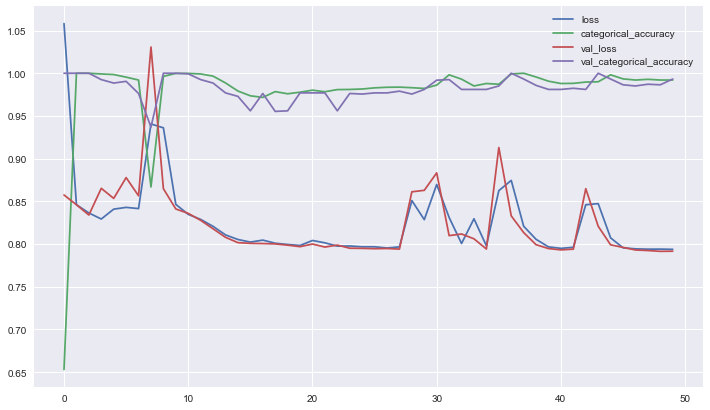

In [262]:
plt.style.use('seaborn')
#plt.figure(figsize=(12,15))
losses_ls.plot(kind = 'line' , figsize=(12,7))

* The curve above shows that at initial epochs there was a fluctuation in val_loss , loss and categorical_accuracy then there is a perfect categorical accuracy with respect to epochs

* After increasing the number of epochs there will be no change in the categorical_accuracy or val_loss or we can say the model gets overfitted thats why we use 50 epochs for training. 

# Thank You